In [1]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

from vgg import *
from utils import *

import matplotlib.pyplot as plt
import os


In [2]:
#set gpu space for user

os.environ["CUDA_VISIBLE_DEVICES"] = '5, 6'
print(torch.cuda.device_count())

2


In [3]:
# Configuration list

CONF = {'A': [64, 'MP', 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
        'B': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 'MP', 512, 512, 'MP', 512, 512, 'MP'],
        'C': [64, 64, 'MP', 128, 128, 'MP', 256, 256, (1, 256), 'MP', 512, 512, (1, 512), 'MP', 512, 512, (1, 512), 'MP'],
        'D': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 'MP', 512, 512, 512, 'MP', 512, 512, 512, 'MP'],
        'E': [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512, 'MP', 512, 512, 512, 512, 'MP']}

L_CONF = {'A': [64, 'MP', 128, 'MP', (5, 256), 'MP', (5, 512), 'MP', (5, 512), 'MP'],
        'B': [(5, 64), 'MP', (5, 128), 'MP', (5, 256), 'MP', (5, 512), 'MP', (5, 512), 'MP'],
        'C': [(5, 64), 'MP', (5, 128), 'MP', (5, 256),(1, 256), 'MP', (5, 512),(1, 512), 'MP', (5, 512),(1, 512), 'MP'],
        'D': [(5, 64), 'MP', (5, 128), 'MP', (7, 256), 'MP', (7, 512), 'MP', (7, 512), 'MP'],
        'E': [(5, 64), 'MP', (5, 128), 'MP', (9, 256), 'MP', (9, 512), 'MP', (9, 512), 'MP']}

# Load data
Load CIFAR10 train data and divide into 2 (train, val)

In [4]:
set_seed(1) #for reproductivity

### original size ###
#get data with each transform
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_train)
val_data = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_val)

# randomly split train and val
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = data.sampler.SubsetRandomSampler(train_idx)
val_sampler = data.sampler.SubsetRandomSampler(val_idx)

lengths = [len(train_sampler), len(val_sampler)]

# load
train_loader = data.DataLoader(train_data, sampler=train_sampler, batch_size=512, num_workers = 2)
val_loader = data.DataLoader(val_data, sampler=val_sampler, batch_size=512, num_workers = 2)

# cifar10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
### resized to 48 (x1.5) and randomly crop the train set ###
transform_train2 = transforms.Compose([
    transforms.Resize(48),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data2 = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform_train2)
train_loader2 = data.DataLoader(train_data2, sampler=train_sampler, batch_size=512, num_workers = 2)

Files already downloaded and verified


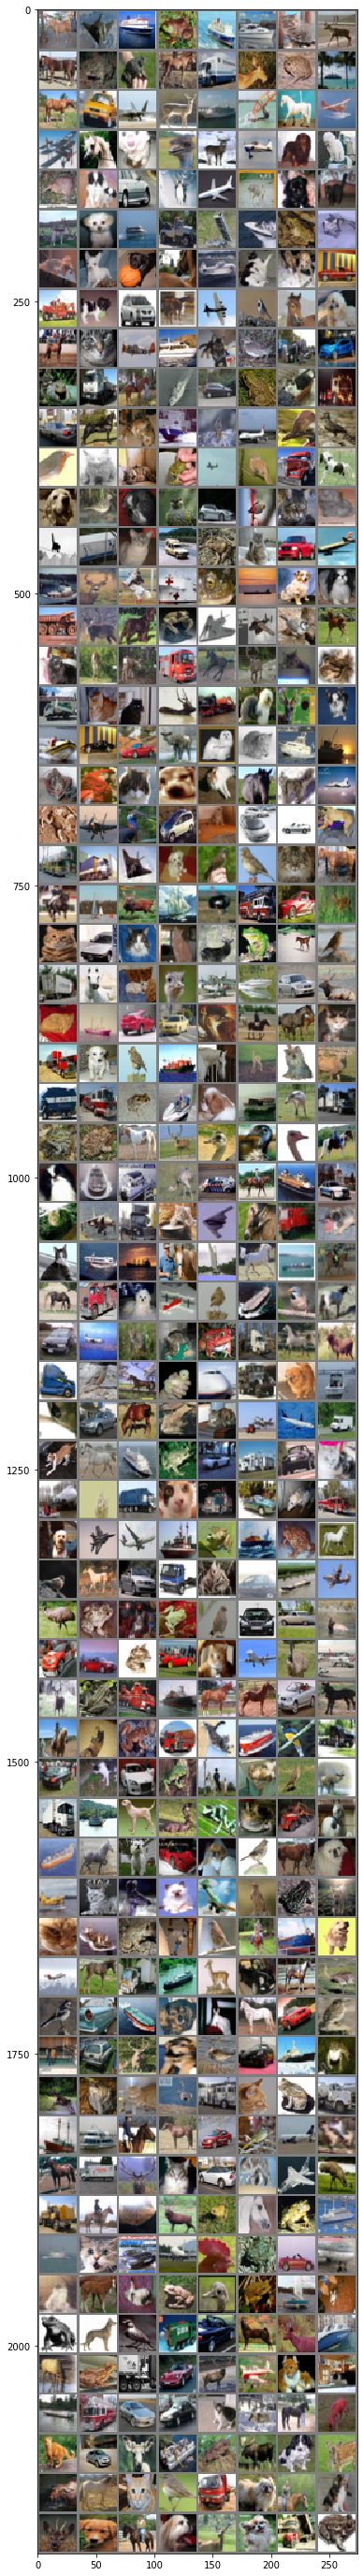

horse plane  ship  frog


In [6]:
# check data
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images), 0.5, 0.5)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 1. VGG_D

In [15]:
### Train ###

vgg_D = VGG(CONF, 'D')

#initialize
A_part = LoadDict('A_part')

vgg_D.apply(weight_reset)
vgg_D.load_state_dict(A_part, False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

D_best, Val_acc_D = train_model(vgg_D, device, train_loader, val_loader, lengths, num_epochs=100)
Acc = {'D' : Val_acc_D}

SaveDict(D_best, 'D_best')
SaveDict(Val_acc_D, 'Val_acc_D')


Epoch 0/99
----------
LR: 0.01
Train Loss: 2.1149 Acc: 0.1836 
Val Loss: 1.7663 Acc: 0.3388

Epoch 1/99
----------
LR: 0.01
Train Loss: 1.6280 Acc: 0.3732 
Val Loss: 1.4855 Acc: 0.4602

Epoch 2/99
----------
LR: 0.01
Train Loss: 1.4162 Acc: 0.4752 
Val Loss: 1.2781 Acc: 0.5252

Epoch 3/99
----------
LR: 0.01
Train Loss: 1.2572 Acc: 0.5424 
Val Loss: 1.6461 Acc: 0.4360

Epoch 4/99
----------
LR: 0.01
Train Loss: 1.1617 Acc: 0.5824 
Val Loss: 1.2053 Acc: 0.5814

Epoch 5/99
----------
LR: 0.01
Train Loss: 1.0376 Acc: 0.6305 
Val Loss: 0.9760 Acc: 0.6504

Epoch 6/99
----------
LR: 0.01
Train Loss: 0.9491 Acc: 0.6619 
Val Loss: 1.0851 Acc: 0.6355

Epoch 7/99
----------
LR: 0.01
Train Loss: 0.8763 Acc: 0.6894 
Val Loss: 0.9700 Acc: 0.6581

Epoch 8/99
----------
LR: 0.01
Train Loss: 0.8192 Acc: 0.7111 
Val Loss: 0.9787 Acc: 0.6643

Epoch 9/99
----------
LR: 0.01
Train Loss: 0.7569 Acc: 0.7360 
Val Loss: 0.7904 Acc: 0.7162

Epoch 10/99
----------
LR: 0.01
Train Loss: 0.7199 Acc: 0.7476 
Val Lo

LR: 1.0000000000000004e-08
Train Loss: 0.0111 Acc: 0.9982 
Val Loss: 0.9423 Acc: 0.8226

Epoch 83/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0104 Acc: 0.9984 
Val Loss: 0.9423 Acc: 0.8226

Epoch 84/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0111 Acc: 0.9979 
Val Loss: 0.9423 Acc: 0.8226

Epoch 85/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0111 Acc: 0.9980 
Val Loss: 0.9423 Acc: 0.8226

Epoch 86/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0108 Acc: 0.9982 
Val Loss: 0.9423 Acc: 0.8226

Epoch 87/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0104 Acc: 0.9982 
Val Loss: 0.9423 Acc: 0.8226

Epoch 88/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0116 Acc: 0.9979 
Val Loss: 0.9423 Acc: 0.8226

Epoch 89/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0103 Acc: 0.9980 
Val Loss: 0.9423 Acc: 0.8226

Epoch 90/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0108 Acc: 0.9982 
Val Loss: 0.9423 Acc: 0.8226

Epoch 91/99
---

0

In [16]:
### Test ###

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform_test)
test_loader = data.DataLoader(test_data, shuffle = True, batch_size=512, num_workers = 2)
length = len(test_data)

vgg_D.load_state_dict(D_best, True)
criterion = nn.CrossEntropyLoss().cuda()

_ = validate(vgg_D, device, test_loader, length, criterion, mode = 'test')


Files already downloaded and verified
Test Loss: 0.8069 Acc: 0.8224


# 2. Equivalent Large Conv Net

In [9]:
#Equivalent large NW with D

LD = VGG(L_CONF,'D')
LD.apply(weight_reset)

LD.to(device)
LD_best, Val_acc_LD = train_model(LD, device, train_loader, val_loader, lengths, num_epochs=100)

SaveDict(LD_best, 'LD_best')
SaveDict(Val_acc_LD, 'Val_acc_LD')

Epoch 0/99
----------
LR: 0.01
Train Loss: 2.1114 Acc: 0.2059 
Val Loss: 1.7637 Acc: 0.3670

Epoch 1/99
----------
LR: 0.01
Train Loss: 1.6961 Acc: 0.3620 
Val Loss: 1.5231 Acc: 0.4383

Epoch 2/99
----------
LR: 0.01
Train Loss: 1.5079 Acc: 0.4432 
Val Loss: 1.3847 Acc: 0.4977

Epoch 3/99
----------
LR: 0.01
Train Loss: 1.3868 Acc: 0.4921 
Val Loss: 1.3037 Acc: 0.5203

Epoch 4/99
----------
LR: 0.01
Train Loss: 1.3088 Acc: 0.5224 
Val Loss: 1.1854 Acc: 0.5696

Epoch 5/99
----------
LR: 0.01
Train Loss: 1.2155 Acc: 0.5598 
Val Loss: 1.1730 Acc: 0.5746

Epoch 6/99
----------
LR: 0.01
Train Loss: 1.1306 Acc: 0.5948 
Val Loss: 1.0868 Acc: 0.6108

Epoch 7/99
----------
LR: 0.01
Train Loss: 1.0545 Acc: 0.6231 
Val Loss: 1.1125 Acc: 0.6029

Epoch 8/99
----------
LR: 0.01
Train Loss: 1.0123 Acc: 0.6387 
Val Loss: 0.9911 Acc: 0.6439

Epoch 9/99
----------
LR: 0.01
Train Loss: 0.9457 Acc: 0.6672 
Val Loss: 0.9368 Acc: 0.6718

Epoch 10/99
----------
LR: 0.01
Train Loss: 0.8926 Acc: 0.6848 
Val Lo

Val Loss: 0.9590 Acc: 0.7710

Epoch 82/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0714 Acc: 0.9789 
Val Loss: 0.9590 Acc: 0.7709

Epoch 83/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0712 Acc: 0.9797 
Val Loss: 0.9590 Acc: 0.7710

Epoch 84/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0710 Acc: 0.9795 
Val Loss: 0.9590 Acc: 0.7710

Epoch 85/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0727 Acc: 0.9785 
Val Loss: 0.9590 Acc: 0.7710

Epoch 86/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0727 Acc: 0.9785 
Val Loss: 0.9590 Acc: 0.7710

Epoch 87/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0722 Acc: 0.9788 
Val Loss: 0.9590 Acc: 0.7710

Epoch 88/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0723 Acc: 0.9780 
Val Loss: 0.9590 Acc: 0.7709

Epoch 89/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0709 Acc: 0.9792 
Val Loss: 0.9590 Acc: 0.7708

Epoch 90/99
----------
LR: 1.0000000000000004e-08
Train Loss: 0.0706 Acc: 

0

In [10]:
### Test ###

LD.load_state_dict(LD_best, True)
_ = validate(LD, device, test_loader, length, criterion, mode = 'test')


Test Loss: 0.9445 Acc: 0.7707
